## Explore and Calculate Metrics for ScanBank

Calculate metrics for ScanBank-processed files.

Because our definitions of figure/figure caption differ, don't apply post processing (probably).

In [155]:
from sys import path
path.append('../')
import config

# set a seed for CV comparision?  Set to None for random
seed = 5
n_folds_cv = 5

In [156]:
# do we want to save our results to .dat files for use in other areas (like tables in latex)
save_dats = True
# which iou's to save?
#ioustar = [0.9] # fig, caption
ioustar = [0.8] # fig, caption
scorestar = 0.1
use_cv = False # only applies to saving of .dat files


# # SCAN BANK -- test how well scanbank does on our images (the final test dataset)
# annotation_files = '/Users/jillnaiman/MegaYolo_test/yolo_512x512_ann/' 
# feature_dir = '/Users/jillnaiman/MegaYolo_test/binaries_model12_finaltest/'
####### pickle_file_loc = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/'
# yolopicklename = 'binaries_model12_finaltest.pickle'
# images_jpeg_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Pages/RandomSingleFromPDFIndexed/' # default
# check_json_dir = None
# pdf_dir = ''
#adder_dats = 'scanbank_on_ours' # what to call output file?


# SCAN BANK -- test how well scanbank does on *its own set of images from ETDs*
annotation_files = '/Users/jillnaiman/MegaYolo_scanbank/yolo_512x512_ann/' 
feature_dir = '/Users/jillnaiman/MegaYolo_scanbank/binaries_model12_scanbank/' # not really used I think?
#######pickle_file_loc = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/'
yolopicklename = 'binaries_model12_scanbank.pickle' # also not sure if this is used?
images_jpeg_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/Pages_scanbank/RandomSingleFromPDFIndexed/'
check_json_dir = '/Users/jillnaiman/deepfigures-results/17' # check for empty json files? set to None to skip
pdf_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/data/scanbank/etds/'
adder_dats = 'scanbank_on_scanbank' # what to call output file?



# # which metric file?
# #binary_dirs = 'binaries_model12_tfrecordz_pmcnoncom/'
# binary_dirs = 'binaries_model12_finaltest/' # final, final test

# use_valid = False





# # pp2 = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/binaries_model12_finaltest.pickle'
# # images_jpeg_dir = None
# # adder_here = ''

# # test how well detectron2 does on our images
# pp2 = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/binaries_model12_finaltest_fbdetect.pickle'
# images_jpeg_dir = None
# adder_here = 'fbdetect'
# ocr_results_dir = None
# save_binary_dir = '/Users/jillnaiman/MegaYolo_test/'
# full_article_pdfs_dir = None
# make_sense_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Annotations/MakeSenseAnnotations_test/'
# ###binary_dirs = 'binaries_model12_finaltest/'# for final test set



# # pp2 = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/binaries_model12_tfrecordz_pmcnoncom_fbdetect.pickle'
# # images_jpeg_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/Pages_pmcnoncom/RandomSingleFromPDFIndexed/'
# # adder_here = 'pmcnon'




# #adder_dats = 'fbdetect_noncom2'



In [157]:
deepfiguresDir = '/Users/jillnaiman/deepfigures-results/' # where results are found from ScanBank

sbann_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/data/scanbank/annotations.json' # scanbank annotation's file

In [158]:
from glob import glob
if check_json_dir is not None:
    missingFiles = []
    jfiles = glob(check_json_dir + '*')
    for jf in jfiles:
        fs = glob(jf+'/*')
        fs = glob(fs[0]+'/*')
        hasJson = False
        for f in fs:
            if 'results.json' in f:
                hasJson = True
        if not hasJson:
            missingFiles.append(jf)
    # write missing to file
    if len(missingFiles) > 0:
        with open(pdf_dir+'testList_missing.csv','w') as fi:
            for m in missingFiles:
                print('/'+m.split('/')[-1]+'_p',file=fi) # weird formatting
    print('there are:', len(missingFiles), 'missing files')

there are: 16 missing files


In [159]:
import pickle
from sys import path
path.append('../')
##import config
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from PIL import Image
import cv2 as cv
import os
import json
from metric_utils import calc_base_metrics_allboxes_cv, calc_prec_rec_f1_cv, print_metrics_table, \
  get_years_dataframe
from general_utils import parse_annotation

In [160]:
if images_jpeg_dir is None: images_jpeg_dir = config.images_jpeg_dir

In [161]:
scoreminVec = [0.1, 0.5, 0.9] # list of minimum box "scores"
iouminVec = [0.1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95] # list of IOU cut offs we want to explore

In [162]:
# # get pickle
pickle_file = config.metric_results_dir +yolopicklename

with open(pickle_file, 'rb') as ff:
    icombo,fnames, truebox, pdfboxes, pdfrawboxes, captionText_figcap,\
                 bbox_figcap_pars,\
                 sboxes_cleaned, slabels_cleaned, sscores_cleaned,\
                 boxes_pdf, labels_pdf, scores_pdf,\
                 boxes_heur, labels_heur, scores_heur,\
                 boxes_heur2, labels_heur2, scores_heur2,\
                 boxes_par_found, labels_par_found, scores_par_found,\
                 boxes_sq1, labels_sq1, scores_sq1,\
                 boxes_sq2, labels_sq2, scores_sq2,\
                 boxes_sq3, labels_sq3, scores_sq3,\
                 boxes_sq4, labels_sq4, scores_sq4,\
                 boxes_sq5, labels_sq5, scores_sq5,\
                 truebox1,truebox2,truebox3,rotatedImages,LABELS,boxes1, scores1, labels1 = pickle.load(ff)
pickle_file

'/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/binaries_model12_scanbank.pickle'

Create combined true boxes and found boxes.

In [163]:
# for AP calc
boxes_true = []; boxes_found = []; labels_found = []; scores_found = []
boxes_true_us = []; boxes_found_us = []; labels_found_us = []; scores_found_us = []

# if there is an error with scanbank, don't count this one:
inds_drop = []

# for each annotation, get true boxes:
for ia,a in enumerate(fnames):
    # ---- get PDF boxes from before -----
    a = annotation_files + a.split('/')[-1].rstrip('.npz') + '.xml'
    imgs_name, true_boxes, pdfboxes, pdfrawboxes = parse_annotation([a], 
                                                                  LABELS, 
                                                                  parse_pdf=True, 
                                                                   check_for_file=False)
    #also save trues for our full processes
    boxes_true_us.append(truebox3[ia])
    boxes_found_us.append(boxes_sq5[ia])
    labels_found_us.append(labels_sq5[ia])
    scores_found_us.append(scores_sq5[ia])
    
    if len(true_boxes) > 0:
        truebox = true_boxes[0] # formatting mess
    else:
        truebox = []
    # no idea, but some formatting things I need to fix
    if len(pdfboxes)> 0:
        pdfboxes = pdfboxes[0]
    else:
        pdfboxes = []
    if len(pdfrawboxes)> 0:
        pdfrawboxes = pdfrawboxes[0]
    else:
        pdfrawboxes = []
        
    # ---- combine trues ---
    rotatedImage = rotatedImages[ia]
    truesComb = []
    boxes_true_fig = []; boxes_true_cap = []; boxesCombTrue = []; boxes_other = []
    # also, save fig+cap combos
    for it,tbox in enumerate(truebox):
        if LABELS[int(tbox[-1]-1)] == 'figure caption':
            boxes_true_cap.append(tbox.copy())
        elif LABELS[int(tbox[-1]-1)] == 'figure':
            if type(tbox) != tuple:
                boxes_true_fig.append(tbox.copy())
            else:
                boxes_true_fig.append(tbox)
        elif LABELS[int(tbox[-1]-1)] == 'table':
            boxes_other.append(tbox)

    # pair
    for ibb,bb in enumerate(boxes_true_fig):
        mind = 5e15; iout = -1
        xc,yc = 0.5*(bb[0]+bb[2]),bb[3]
        if rotatedImage:
            xc, yc = bb[2], 0.5*(bb[1]+bb[3])
        for ic,bc in enumerate(boxes_true_cap): # find closest to bottom, not inside a square
            xcc,ycc= 0.5*(bc[0]+bc[2]),0.5*(bc[1]+bc[3])
            d = np.sum(((xc-xcc)**2 + (yc-ycc)**2)**0.5)
            if d < mind:
                mind = d
                iout = ic
        if iout > -1: # if we found a mega-yolo-found caption, add it
            boxesCombTrue.append( (min(boxes_true_fig[ibb][0],boxes_true_cap[iout][0]),
                                   min(boxes_true_fig[ibb][1],boxes_true_cap[iout][1]),
                                   max(boxes_true_fig[ibb][2],boxes_true_cap[iout][2]),
                                   max(boxes_true_fig[ibb][3],boxes_true_cap[iout][3]), 
                                  LABELS.index('figure')+1) ) # 0 = placeholder tag
            # also add caption
            boxesCombTrue.append( (boxes_true_cap[iout][0],boxes_true_cap[iout][1],
                                   boxes_true_cap[iout][2],boxes_true_cap[iout][3], 
                                  LABELS.index('figure caption')+1) ) # 0 = placeholder tag
        else: # if no, just take fig
            boxesCombTrue.append( (boxes_true_fig[ibb][0], boxes_true_fig[ibb][1], 
                                  boxes_true_fig[ibb][2], boxes_true_fig[ibb][3], 
                                  LABELS.index('figure')+1) )
    #print(len(boxes_true_fig), len(boxesCombTrue))
    #ttt += len(boxes_true_fig)
    truesComb.append(boxesCombTrue)
    boxes_true.append(boxesCombTrue)
    

        
    # get the deepfigures results
    pdfbase = a.split('/')[-1].split('_p')[0]
    dname = deepfiguresDir+pdfbase
    #allFigs = []; allScores=[]; allLabels=[]
    myRaw = []; myFigs = []; myFullFigs = []; foundLabels = []; scores = []
    try:
        f = glob(dname + '/*')[0]
    except:
        print('no file for', dname)
        f = '-1'
        import sys; sys.exit()
    # is something there?
    if os.path.isfile(f+'/'+pdfbase+'deepfigures-results.json'):
        # get json file
        with open(f+'/'+pdfbase+'deepfigures-results.json','r') as ff:
            fj = json.loads(ff.read())

        # translation coordinates info
        # get dpi
        dpi = fj['dpi']
        # get fig page with this dpi
        page = int(a.split('_p')[-1].split('.xml')[0])
        pageName = f+'/'+pdfbase+'.pdf-images/ghostscript/dpi'+str(dpi)+'/'+\
           pdfbase+'.pdf-dpi'+str(dpi)+'-page'+str(page+1).zfill(4)+'.png'
        # read and get size
        imgDraw = Image.open(pageName)
        imgDPIsize = imgDraw.size

        # only want objects on our specific page
        figsThisPage = []
        for f in fj['figures']:
            #print(f)
            if f['page'] == page:
                figsThisPage.append(f)

        # also track raw boxes
        rawBoxThisPage = []
        for ib, boxes in enumerate(fj['raw_detected_boxes']):
            if ib == page:
                rawBoxThisPage = boxes
                    
        # and finally, raw PDF figures
        pdfFiguresThisPage = []
        for pdff in fj['raw_pdffigures_output']['figures']:
            if pdff['page'] == page:
                pdfFiguresThisPage.append(pdff)
                
        # get PDF-to-YOLO
        fracx = imgDPIsize[0]/config.IMAGE_W; fracy = imgDPIsize[1]/config.IMAGE_H
        
        # grab stuffs

        # Grab raw boxes (sometimes fig boxes aren't found but they are in raw boxes)
        for b in rawBoxThisPage:
            x1 = b['x1']
            y1 = b['y1']
            x2 = b['x2']
            y2 = b['y2']
            # transform from PDF to scanned axis
            y1 = int(round(y1/fracy)); y2 = int(round(y2/fracy))
            x1 = int(round(x1/fracx)); x1 = int(round(x2/fracx))
            myRaw.append((x1,y1,x2,y2,-1))

        # get figures from deepfigs
        for f in figsThisPage:
            x1 = f['figure_boundary']['x1'] 
            y1 = f['figure_boundary']['y1']
            x2 = f['figure_boundary']['x2'] 
            y2 = f['figure_boundary']['y2']
            y1 = int(round(y1/fracy)); y2 = int(round(y2/fracy))
            x1 = int(round(x1/fracx)); x2 = int(round(x2/fracx))

            # include captions
            x1c = f['caption_boundary']['x1'] 
            y1c = f['caption_boundary']['y1']
            x2c = f['caption_boundary']['x2'] 
            y2c = f['caption_boundary']['y2']
            y1c = int(round(y1c/fracy)); y2c = int(round(y2c/fracy))
            x1c = int(round(x1c/fracx)); x2c = int(round(x2c/fracx))

            # fig/cap pairs
            if f['figure_type'] == 'Figure':
                myFullFigs.append( (min(x1,x1c),min(y1,y1c),max(x2,x2c),max(y2,y2c)) )
                foundLabels.append( LABELS.index('figure') )
                # also, get captions
                myFullFigs.append( (x1c,y1c,x2c,y2c))
                scores.append(1.0)       
                foundLabels.append( LABELS.index('figure caption') )
            elif f['figure_type'] == 'Table':
                xmin = min([x1,x1c]); xmax = max([x2,x2c]); ymin = min([y1,y1c]); ymax = max([y2,y2c])
                myFullFigs.append( (min(x1,x1c),min(y1,y1c),max(x2,x2c),max(y2,y2c)) )
                foundLabels.append(LABELS.index('table') )
                scores.append(1.0)
            else:
                print('no idea')
                import sys; sys.exit()
        #allFigs.append(myFullFigs)
        #allLabels.append(foundLabels)
        #allScores.append(scores)
    else:
        inds_drop.append(ia)
                
    boxes_found.append(myFullFigs)
    labels_found.append(foundLabels)
    scores_found.append(scores)

In [164]:
len(boxes_true),len(boxes_found), len(boxes_found_us)

(748, 748, 748)

In [165]:
len(inds_drop)

184

In [166]:
boxes_true[1]

[(124.0, 260.0, 441.0, 461.0, 1),
 (124.0, 430.0, 441.0, 461.0, 2),
 (139.0, 44.0, 433.0, 232.0, 1),
 (139.0, 217.0, 433.0, 232.0, 2)]

In [167]:
boxes_found[1]

[]

In [192]:
dfall = pd.DataFrame({'true_sb':boxes_true, 
                      'found_sb':boxes_found, 'labels_sb':labels_found, 'scores_sb':scores_found, 
                      'true':boxes_true_us, 
                      'found':boxes_found_us, 'labels':labels_found_us, 'scores':scores_found_us})

dfall = dfall.drop(dfall.index[inds_drop])
dfall = dfall.reset_index(drop=True)

boxes_true=dfall['true_sb'].values
boxes_found=dfall['found_sb'].values
labels_found=dfall['labels_sb'].values
scores_found=dfall['scores_sb'].values

In [193]:
dfall

,true_sb,found_sb,labels_sb,scores_sb,true,found,labels,scores
0,[],[],[],[],"[[12.0, 107.0, 431.0, 419.0, 3.0]]",[],[],[]
1,"[(124.0, 260.0, 441.0, 461.0, 1), (124.0, 430....",[],[],[],"[[124.0, 430.0, 441.0, 461.0, 2.0], [124.0, 26...","[[123.8, 429.75845410628017, 440.8, 446.454106...","[1, 0, 1, 0]","[0.9989958, 0.9989994, 0.99125016, 0.9856077]"
2,[],[],[],[],[],"[[205.65615844726562, 256.89666748046875, 463....",[2],[0.9987776]
3,[],[],[],[],[],[],[],[]
4,[],[],[],[],"[[98.0, 213.0, 435.0, 277.0, 3.0]]",[],[],[]
...,...,...,...,...,...,...,...,...
559,[],[],[],[],[],[],[],[]
560,[],[],[],[],[],[],[],[]
561,[],[],[],[],[],[],[],[]
562,"[(57.0, 104.0, 459.0, 328.0, 1)]",[],[],[],"[[57.0, 104.0, 459.0, 328.0, 1.0]]",[],[],[]


In [194]:
#dfall.iloc[0], LABELS

In [216]:
# how many true of each class?
labels_done_count = np.zeros(len(LABELS))
for i in range(len(dfall)):
    for l in dfall.iloc[i]['true']:
        labels_done_count[int(l[-1]-1)] += 1
print('Done per category:')
for i in range(len(LABELS)):
    print(LABELS[i], labels_done_count[i])

Done per category:
figure 121.0
figure caption 86.0
math formula 135.0
table 43.0


Test one:

In [217]:
hasbox = []
for i in range(len(dfall)):
    if len(dfall.iloc[i]['true_sb']) > 0:
        hasbox.append(i)
print(hasbox)

[1, 6, 16, 38, 40, 44, 45, 46, 50, 52, 63, 76, 81, 82, 94, 101, 103, 111, 116, 129, 135, 137, 148, 155, 162, 171, 173, 174, 183, 185, 188, 192, 195, 198, 200, 209, 212, 214, 215, 222, 228, 230, 232, 233, 234, 236, 244, 251, 252, 253, 256, 257, 261, 264, 269, 270, 279, 285, 288, 289, 300, 302, 304, 316, 320, 321, 323, 332, 334, 351, 354, 365, 368, 376, 381, 382, 383, 384, 386, 387, 390, 391, 400, 401, 402, 405, 406, 407, 408, 409, 414, 415, 429, 449, 455, 457, 463, 471, 474, 487, 489, 493, 499, 502, 520, 526, 537, 539, 540, 543, 546, 557, 558, 562]


In [218]:
indb = 12

In [219]:
dfall.iloc[indb]

true_sb                                                     []
found_sb                                                    []
labels_sb                                                   []
scores_sb                                                   []
true                                                        []
found        [[143.1412353515625, 243.0267333984375, 356.46...
labels                                                     [2]
scores                                            [0.39696473]
Name: 12, dtype: object

In [220]:
dfall.iloc[indb]['found'], dfall.iloc[indb]['labels']

([array([143.14123535, 243.0267334 , 356.46417236, 258.18890381])], [2])

In [221]:
dfall.iloc[indb]['true'][::-1]

[]

In [222]:
# TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
#                                               [dfall.iloc[4]['true']],[dfall.iloc[4]['found']],
#                                                           [dfall.iloc[4]['labels']], 
#                                               [dfall.iloc[4]['scores']],
#                                                           n_folds_cv=n_folds_cv,
#                                                          seed=seed)
from metric_utils import new_calcs
ioumin = 0.1
trueshere = dfall.iloc[indb]['true'][::-1]
new_calcs(trueshere,dfall.iloc[indb]['found'],
          dfall.iloc[indb]['labels'],dfall.iloc[indb]['scores'],
                               np.repeat(ioumin,len(LABELS)), 
                               '1000_placeholder', np.arange(len(LABELS)))

{2: {'TP': 0.0,
  'FP': 1.0,
  'FN': -1.0,
  'npos': 0,
  'year': 1000,
  'name': '1000_placeholder'}}

In [223]:
fnames[:2], images_jpeg_dir

(['/Users/jillnaiman/MegaYolo_scanbank/binaries_model12_scanbank/1721_1_117257_p52.npz',
  '/Users/jillnaiman/MegaYolo_scanbank/binaries_model12_scanbank/1721_1_17465_p68.npz'],
 '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/Pages_scanbank/RandomSingleFromPDFIndexed/')

In [224]:
labels_found[:5]

array([list([]), list([]), list([]), list([]), list([])], dtype=object)

Also read in the ScanBank annotations.

In [225]:
with open(sbann_dir,'r') as ff:
    sba = json.loads(ff.read())

In [226]:
sba.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

It seems like only figures are annotated?

In [227]:
sba['categories']

[{'supercategory': 'figure', 'id': 1, 'name': 'figure'}]

In [228]:
#sba['images']

In [229]:
cat_ids = []
for sb in sba['annotations']:
    cat_ids.append(sb['category_id'])

In [230]:
np.unique(cat_ids)

array([1])

So indeed, looks like just figures.

In [231]:
fnames[297]

'/Users/jillnaiman/MegaYolo_scanbank/binaries_model12_scanbank/1721_1_13329_p10.npz'

[184 320 430]


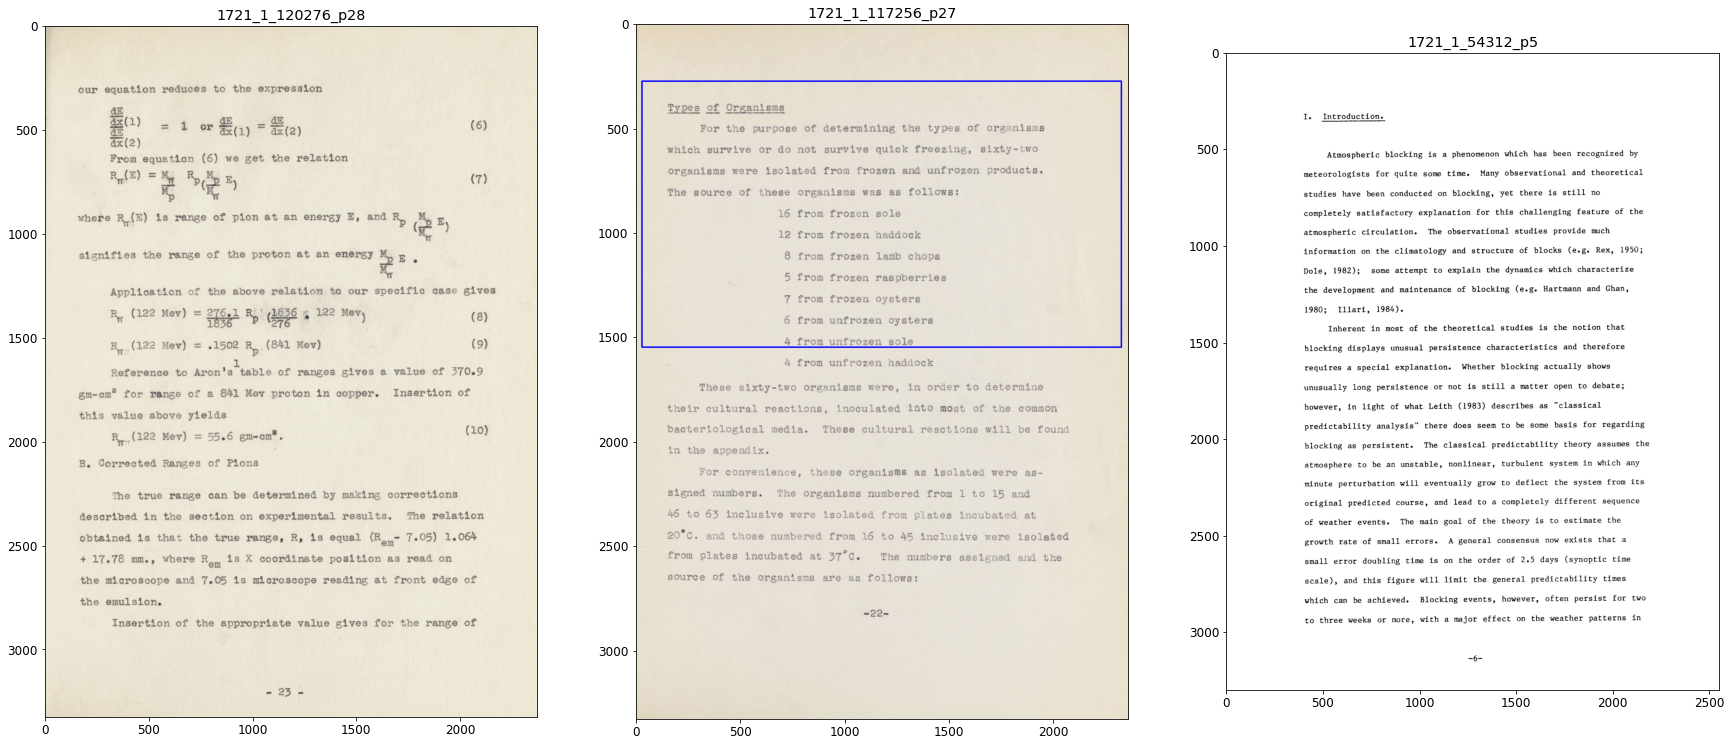

In [232]:
nr = 3
inds = np.random.randint(0,len(boxes_true), nr)
# has figs: 297, 360, 519, 510
##inds = [510, 297, 360]
print(inds)

fig, ax = plt.subplots(1,nr,figsize=(30,20))

for i,ind in enumerate(inds):
    fn = fnames[ind].split('/')[-1].rstrip('.npz')
    img = np.array(Image.open(images_jpeg_dir+ fn+'.jpeg').convert('RGB'))

    # found in red
    for fb,cfb in zip(boxes_found[ind],labels_found[ind]):
        xmin1 = fb[0]/config.IMAGE_W*img.shape[1]
        xmax1 = fb[2]/config.IMAGE_W*img.shape[1]
        ymin1 = fb[1]/config.IMAGE_H*img.shape[0]
        ymax1 = fb[3]/config.IMAGE_H*img.shape[0]
        if LABELS[cfb] == 'figure':
            cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (255, 175, 0), 7)
        else:
            cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (255, 0, 0), 7)  

    for fb in boxes_true[ind]:
        xmin1 = fb[0]/config.IMAGE_W*img.shape[1]
        xmax1 = fb[2]/config.IMAGE_W*img.shape[1]
        ymin1 = fb[1]/config.IMAGE_H*img.shape[0]
        ymax1 = fb[3]/config.IMAGE_H*img.shape[0]
        cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (0, 0, 255), 5)  
        
    ax[i].imshow(img)
    ax[i].set_title(fn)

plt.show()

In [233]:
#boxes_true[297]

In [234]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
                                              boxes_true,boxes_found,labels_found, 
                                              scores_found,n_folds_cv=n_folds_cv,
                                                         seed=seed)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouminVec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


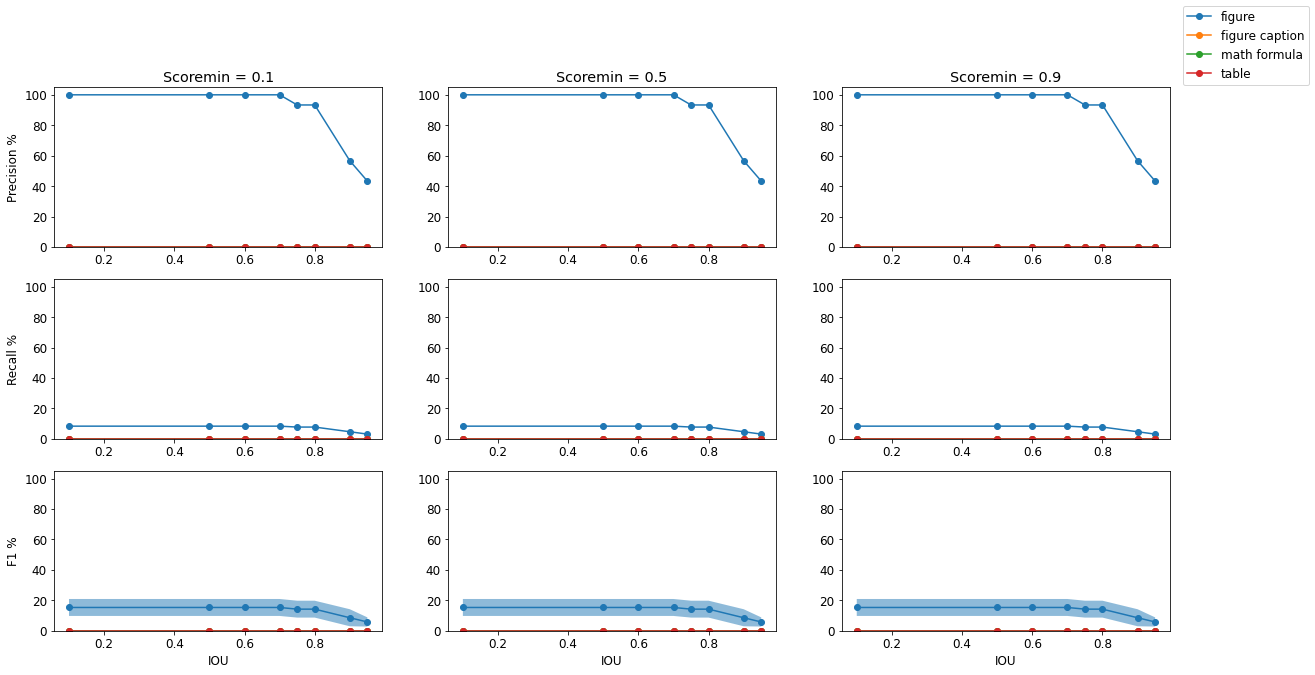

In [235]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouminVec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouminVec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouminVec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouminVec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

In [236]:
scoremin = 0.1

#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[0.8,0.8,0.8,0.8],
                                              boxes_true,boxes_found,labels_found, 
                                              scores_found,n_folds_cv=n_folds_cv,
                                                         seed=seed)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               [0.8,0.8,0.8,0.8])
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, [0.8,0.8,0.8,0.8])

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       121             86              0               0              
--------------------------------------------------------------------------------------------
TP              7.4%            0.0%            nan%            nan%           
FP              0.8%            1.2%            nan%            inf%           
FN              91.7%           98.8%           nan%            nan%           
--------------------------------------------------------------------------------------------
Precision       93.3+/-13.3%    0.0+/-0.0%      0.0+/-0.0%      0.0+/-0.0%     
Recall          7.8+/-3.3%      0.0+/-0.0%      0.0+/-0.0%      0.0+/-0.0%     
F1              14.2+/-5.5%     0.0+/-0.0%      0.0+/-0.0%      0.0+/-0.0%     


../metric_utils.py:689: RuntimeWarning: invalid value encountered in double_scalars
  out.append( str(round(TP[i]/totalTrue[i]*100,1))+'%' )
../metric_utils.py:695: RuntimeWarning: invalid value encountered in double_scalars
  out.append( str(round(FP[i]/totalTrue[i]*100,1))+'%' )
../metric_utils.py:695: RuntimeWarning: divide by zero encountered in double_scalars
  out.append( str(round(FP[i]/totalTrue[i]*100,1))+'%' )
../metric_utils.py:701: RuntimeWarning: invalid value encountered in double_scalars
  out.append( str(round(FN[i]/totalTrue[i]*100,1))+'%' )


## Save to .dat files if requested

In [60]:
import os

adder_dats += adder_here

In [61]:
if save_dats:
    # save too
    #out_num_name = binary_dirs.split('/')[0]+adder_dats
    out_num_name = adder_dats
    num_out_file = config.save_table_dats_dir + out_num_name
    #ioumin_per_labels = [0.1, 0.6, 0.8, 0.9, 0.95]
    #if out_num_name != 'main':
    if not os.path.exists(num_out_file+'/'):
        os.makedirs(num_out_file+'/')
    ioumin_per_labels = ioustar # just the one for our decisions
    num_out_file += '/' + out_num_name
    # how many labels to save up to?
    lend = 2

    n_cv_here = n_folds_cv
    if not use_cv: n_cv_here = 1    
    
    # save to file
    with open(num_out_file + '_score.dat','w') as fnum:
        print(scorestar, file=fnum, end='')
    with open(num_out_file + '_ncv.dat','w') as fnum:
        print(n_folds_cv, file=fnum, end='')


    TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,[scorestar],ioustar,
                                                  trueshere,boxes_fb,labels_fb, 
                                              scores_fb,n_folds_cv=n_cv_here,
                                                             seed=seed)

    precision, precision_std, recall, \
      recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                                   LABELS,[scorestar],
                                                   ioustar)


    # print out total true
    for il,m in enumerate(totalTruev[:lend].sum(axis=-1)):
        with open(num_out_file + '_totTrue_'+LABELS[il].replace(' ','_')+'.dat','w') as fnum:
            print(int(m), file=fnum, end='')

    # print out TP
    for ii,iou in enumerate(ioustar):
        iouhere = str(iou).replace('.','p')

        TP = TPv[:,0,ii,:].sum(axis=-1)
        FP = FPv[:,0,ii,:].sum(axis=-1)
        FN = FNv[:,0,ii,:].sum(axis=-1)

        for il,m in enumerate(TP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_TP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FN[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FN_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            dat = str(np.round(precision[il,0,ii],1))+'$\pm$' +str(np.round(precision_std[il,0,ii],1))
            with open(num_out_file + '_prec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            dat = str(np.round(recall[il,0,ii],1))+'$\pm$' +str(np.round(recall_std[il,0,ii],1))
            with open(num_out_file + '_rec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            dat = str(np.round(f1[il,0,ii],1))+'$\pm$' +str(np.round(f1_std[il,0,ii],1))
            with open(num_out_file + '_f1_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

    print('all done!')